In [36]:
# import Libraries
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, TimeDistributed, Flatten, Dense, Dropout, Bidirectional, LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [37]:
# Dataset directory (flat structure with video files)
DATASET_PATH = r"D:\6. WIN SEM -- 2024-2025\F1. DL\Child Surveillance DL Project\Datasets\2. Activity Monitoring\UCF101\ucf101_top5\train"

In [38]:
# Extract class names from filenames (first part after 'v_')
all_files = [f for f in os.listdir(DATASET_PATH) if f.endswith(".avi")]
CLASSES = sorted(list(set([f.split('_')[1] for f in all_files])))
label_map = {label: idx for idx, label in enumerate(CLASSES)}


In [39]:
IMG_SIZE = 64
SEQUENCE_LENGTH = 20
SAMPLES_PER_CLASS = 20


In [40]:
# Helper to extract frames from the video
def extract_frames(video_path, max_frames=SEQUENCE_LENGTH):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frame = frame / 255.0
        frames.append(frame)
    cap.release()
    
    while len(frames) < max_frames:
        frames.append(np.zeros((IMG_SIZE, IMG_SIZE, 3)))
    
    return np.array(frames)


In [41]:
# Data Preparation
X, y = [], []
class_sample_count = {cls: 0 for cls in CLASSES}

for file in all_files:
    class_name = file.split('_')[1]
    if class_sample_count[class_name] >= SAMPLES_PER_CLASS:
        continue
    video_path = os.path.join(DATASET_PATH, file)
    frames = extract_frames(video_path)
    X.append(frames)
    y.append(label_map[class_name])
    class_sample_count[class_name] += 1

X = np.array(X)
y = to_categorical(y, num_classes=len(CLASSES))

print(f"Loaded {len(X)} samples with shape {X.shape[1:]}")


Loaded 100 samples with shape (20, 64, 64, 3)


In [42]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)


Training shape: (80, 20, 64, 64, 3)
Testing shape: (20, 20, 64, 64, 3)


In [43]:
# Building CNN + Bidirectional LSTM.
model = Sequential([
    TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=(SEQUENCE_LENGTH, IMG_SIZE, IMG_SIZE, 3)),
    TimeDistributed(MaxPooling2D(2,2)),
    
    TimeDistributed(Conv2D(64, (3,3), activation='relu')),
    TimeDistributed(MaxPooling2D(2,2)),
    
    TimeDistributed(Flatten()),
    
    Bidirectional(LSTM(64)),
    
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(CLASSES), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeD  (None, 20, 62, 62, 32)    896       
 istributed)                                                     
                                                                 
 time_distributed_25 (TimeD  (None, 20, 31, 31, 32)    0         
 istributed)                                                     
                                                                 
 time_distributed_26 (TimeD  (None, 20, 29, 29, 64)    18496     
 istributed)                                                     
                                                                 
 time_distributed_27 (TimeD  (None, 20, 14, 14, 64)    0         
 istributed)                                                     
                                                                 
 time_distributed_28 (TimeD  (None, 20, 12544)        

In [44]:
# Model Training
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=4,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)


Epoch 1/20
20/20 [==============================] - 68s 619ms/step - loss: 1.6047 - accuracy: 0.1750 - val_loss: 1.4919 - val_accuracy: 0.3500
Epoch 2/20
20/20 [==============================] - 13s 650ms/step - loss: 1.4668 - accuracy: 0.4125 - val_loss: 1.3002 - val_accuracy: 0.6000
Epoch 3/20
20/20 [==============================] - 15s 743ms/step - loss: 1.0850 - accuracy: 0.7000 - val_loss: 0.8554 - val_accuracy: 0.8000
Epoch 4/20
20/20 [==============================] - 12s 578ms/step - loss: 0.7485 - accuracy: 0.8500 - val_loss: 0.5176 - val_accuracy: 1.0000
Epoch 5/20
20/20 [==============================] - 13s 648ms/step - loss: 0.4862 - accuracy: 0.9250 - val_loss: 0.2847 - val_accuracy: 1.0000
Epoch 6/20
20/20 [==============================] - 13s 637ms/step - loss: 0.2121 - accuracy: 1.0000 - val_loss: 0.1146 - val_accuracy: 1.0000
Epoch 7/20
20/20 [==============================] - 12s 578ms/step - loss: 0.1825 - accuracy: 0.9875 - val_loss: 0.0928 - val_accuracy: 1.0000

In [50]:
# Evaluating the model.
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


1/1 [==============================] - 0s 277ms/step - loss: 0.0061 - accuracy: 1.0000
Test Loss: 0.0061
Test Accuracy: 100.00%


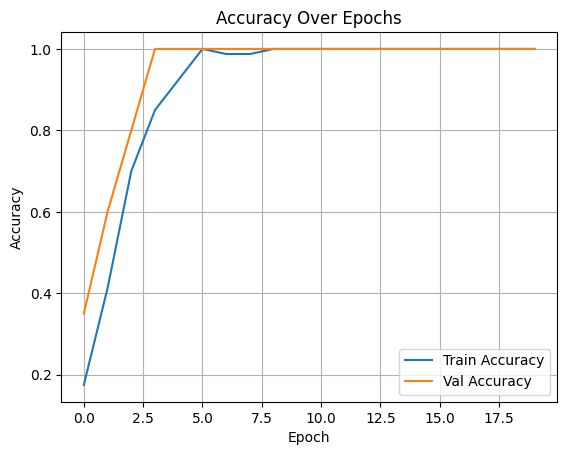

In [51]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title("Accuracy Over Epochs")
plt.show()


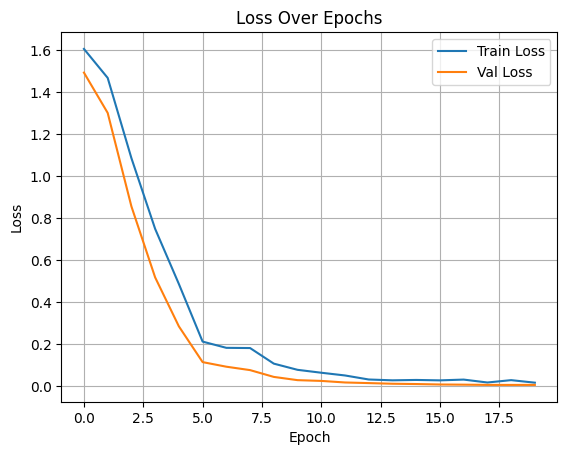

In [52]:
# Plot accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title("Loss Over Epochs")
plt.show()


In [53]:
model.save("activity_monitoring.keras")